In [1]:
from __future__ import division

import collections
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from sklearn.decomposition import PCA

## NN libs
import keras
from keras import backend as K
from keras import regularizers
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras.layers import *
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import TensorBoard

/usr/local/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import config
import os, numpy as np, pandas, sklearn, scipy.signal as signal
import mido
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# local libs
import config, models, setup, compression, ncd_evaluation
import midi
import midi.decode
from midi import generators as g
from utils import io, models_io, utils, plot, string
from capsule.layers import Capsule, Length
from capsule.capsulefunctions import squash, softmax, margin_loss

In [4]:
context = setup.init(max_bars=4)

 Context :: namedtuple(
[ max_t = float
, dt = float
, n_timestesp = int
, note_length = int
, bpm = float
, tempo = float
, ticks_per_beat = int
]

Setting up params

max min f 20.0 0.25
 >> Context(max_t=4.0, dt=0.025, n_timesteps=160, note_length=0.03, bpm=120.0, tempo=500000, ticks_per_beat=480)
 sample length:  160.000000
 max_f: 20.000000, min_f: 0.250000


In [5]:
n = 500 * 1
dim4 = True
multiTrack = True
reduce_dims = midi.ReduceDimsOptions.NONE # GLOBAL
dn = 'drum_midi/'
v = None # float | None
x_train, labels = setup.import_data(context, n, dim4=dim4, reduce_dims=reduce_dims, 
    dirname=dn, multiTrack=multiTrack, velocity=v, r=True)


Importing midi-data
walk_and_search(../datasets/drum_midi/)
path ../datasets/drum_midi/
path ../datasets/drum_midi/50´s Drummer MIDI Files
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM
  01 8th Hat.mid
  02 8th Ride.mid
  03 16th Snare.mid
  04 8th Ride.mid
  05 16th Ride.mid
  06 16th Ride.mid
  07 16th Ride.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM
  01 8th Hat.mid
  02 8th Snare.mid
  03 4th Snare .mid
  04 8th Ride.mid
  05 8th Snare.mid
  06 8th Toms.mid
  07 8th Toms.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/03 Lips n Hips 152BPM
  01 8th Perc.mid
  02 8th Ride.mid
  03 8th Ride .mid
  04 8th Snare.mid
  05 8th Snare.mid
  06 8th Hat.mid
  07 8th Snare.mid
path ../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/04 Maybelline 233BPM
  01 8th Snare.mid
  02 8th Cym.mid
  03 8th Ride.mid
  04 16t


Encoding midi-data
 500
> -> multi-track = True none
 [INFO] : 
 |  True


In [6]:
genres = [string.extract_labels_from_filename(k) for k in labels]
# genre_dict = setup.build_label_dict(genres)

In [7]:
[(i,k) for i,k in enumerate(labels)]

[(0,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/01 8th Hat.mid"),
 (1,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/02 8th Ride.mid"),
 (2,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/03 16th Snare.mid"),
 (3,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/04 8th Ride.mid"),
 (4,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/05 16th Ride.mid"),
 (5,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/06 16th Ride.mid"),
 (6,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/01 Dancin Rick 166BPM/07 16th Ride.mid"),
 (7,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM/01 8th Hat.mid"),
 (8,
  "../datasets/drum_midi/50´s Drummer MIDI Files/01 Rock'n'Roll/02 Gogo 191BPM/02 8th Snare.mid"),
 (9,
  "../datasets/

In [8]:
genres[0][-2:]

["01 Rock'n'Roll", '01 Dancin Rick 166BPM']

In [9]:
unique_genres = set(genre[-1] for genre in genres)
len(unique_genres)

72

In [10]:
x_train.shape

(500, 160, 10, 1)

In [11]:
m = int(x_train.shape[0] * 0.9)
x_train.shape, m

((500, 160, 10, 1), 450)

In [12]:
x_test = x_train[m:]
x_train = x_train[:m]

In [13]:
# genres = [string.extract_labels_from_filename(k) for k in labels]
genre_dict = setup.build_label_dict(genres[:m])

In [14]:
input_shape = x_train[0].shape
timesteps = input_shape[0]
notes = input_shape[1]
input_shape

(160, 10, 1)

In [15]:
latent_dim = 10
epsilon_std = 1.0

In [16]:
vae, encoder, generator = models.build(input_shape, latent_dim)

/Users/mark/src/pattern-recognition/src/models.py:134: UserWarning: Output "reshape_2" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "reshape_2" during training.
  vae.compile(optimizer='adam')


In [17]:
batch_size = 128
epochs = 500

In [18]:
# phase_mod = 0.01
# whitening = False

In [19]:
# m = 1000
# useDataGenerator = False
# # useDataGenerator = True
# callbacks = [TensorBoard(log_dir=config.tmp_log_dir)]

# x = x_train[:m]
# # x = x_train
# # i = [0,1, 7,8, 14,15, 399,400]
# # x = x_train[i]
# # x = np.concatenate([x for _ in range(10)])
# print('x:', x.shape)

# print('batch_size: %i' % batch_size)
# print('update-iterations:', round(epochs * x.shape[0] / batch_size))
# if useDataGenerator:
#     datagen = models.ImageDataGenerator(x_train, batch_size, phase_mod, whitening)
#     history = collections.defaultdict(list)
#     n_batches = datagen.__len__()
#     for e in range(epochs):
#         print('\n[Epoch %i/%i] >>>>>>>>>' % (e, epochs))
#         for batch_i, (x_batch, y_batch) in enumerate(datagen.flow(x, x, batch_size)):
#             print(' Batch %i/%i' % (batch_i,n_batches))
#             x_ = x_batch
#             # x_ = datagen.shuffle_3rd_dim(x_)
#             # x_ = datagen.shuffle_3rd_dim_soft(x_, rate=0.5, scale=0.1, verbose=0)
#             h = vae.fit(x_, validation_data=(x_test, None), verbose=0)
#             for k,v in h.history.items(): 
#                 print(' \\_%s' % k, [round(v_,) for v_ in v])
#                 history[k].append(v)
#             if batch_i >= n_batches:
#                 break
# else:
#     h = vae.fit(x, epochs=epochs, validation_data=(x_test, None), callbacks=callbacks)
#     history = h.history

In [266]:
fn = config.model_dir + 'hi_res-v3p-4_vae.h5'
# fn = config.model_dir + 'hi_res2c_vae.h5'
fn = config.model_dir + 'final_model-500-.h5'

In [267]:
# io.save_dict('../logs/','train_loss', history)

In [268]:
# # for suffix, model in [('vae',vae), ('encoder',encoder), ('gen',generator)]:
# #     model.save_weights(dn + prefix + suffix + '.h5', "w")
# vae.save_weights(fn, "w")

In [269]:
vae.load_weights(fn)

In [24]:
# plt.plot(history['loss'])
# plt.plot(history['val_loss'])
# plt.ylim(0,150)

m (50, 10, 1)


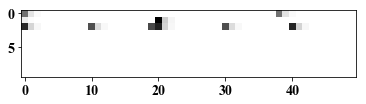

m (50, 10, 1)


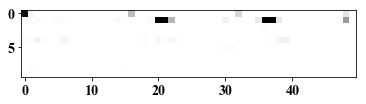

m (50, 10, 1)


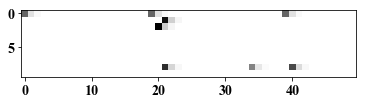

m (50, 10, 1)


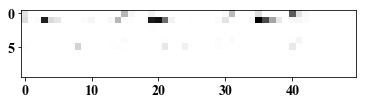

In [264]:
i,j = 0, 10
m = 50
y = vae.predict(x_train[:500])
plot.single(x_train[i,:m])
plot.single(y[i,:m])
plot.single(x_train[j,:m])
plot.single(y[j,:m])

In [26]:
# x = datagen.shuffle_3rd_dim_soft(x_train[:10], rate=1, intensity=2, scale=1, verbose=1)
# i = 0
# plot.single(x_train[i,:,:,0])
# plot.single(x[i,:,:,0])
# x_ = vae.predict(x)
# plot.single(x_[i,:,:,0])

In [27]:
# # min: these pixels are 'always' active
# m = x.min(axis=0)
# plot.multi(m[:30,:,0])

In [28]:
# # mean
# m = x.mean(axis=0)
# plot.single(m[:30,:,0])

## Style transfer

In [29]:
m = 1000
x_train_encoded = encoder.predict(x_train[:m], batch_size=batch_size)
x_train_encoded.shape

(450, 10)

In [30]:
# dn = config.plots_dir + 'transformations.pkl'
# io.save(transformations, fn)
# # transformation_extraction.save_to_disk(transformations, dn, v=1)

# fn = config.plots_dir + 'min_transformations.pkl'
# io.save(min_transformations, fn)
# # transformation_extraction.save_to_disk(min_transformations, dn)

In [31]:
fn = config.plots_dir + 'transformations-best_dims.pkl'
best_dims = io.load(fn)
fn = config.plots_dir + 'transformations.pkl'
transformations = io.load(fn)
fn = config.plots_dir + 'min_transformations.pkl'
min_transformations = io.load(fn)

(array([ 86.,  46.,  86.,  42.,  97.,  54.,  93., 161., 101., 229.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

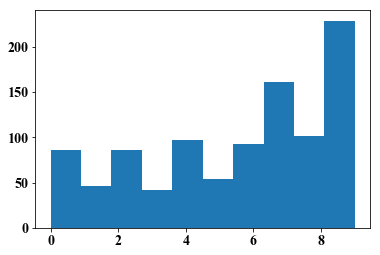

In [32]:
plt.hist(best_dims)

In [33]:
# transformations = io.read_categorical_dict_dir(config.plots_dir + 'transformations/')
# min_transformations = io.read_categorical_dict_dir(config.plots_dir + 'min_transformations/') 

In [34]:
list(transformations.keys())[:3]

['07 Indie/05 Halftime 71BPM',
 '04 Country/08 Eddie Ed 111BPM',
 '01 Rock n Roll/07 Domino 167BPM']

In [35]:
len(transformations.keys())

103

In [36]:
# io.save(result, config.plots_dir + 'ncd_evaluation_results.pkl')
labelled_result = io.load(config.plots_dir + 'ncd_evaluation_results.pkl')

In [37]:
def sample_dict(d, i=0):
    k = list(d.keys())[i]
    return k, d[k]

In [255]:
sample, _ = sample_dict(labelled_result)
sample

'05 Jazz/09 West Coast 152BPM Brushes'

In [39]:
genre_a,_ = sample_dict(labelled_result[sample])
genre_b, scores = sample_dict(labelled_result[sample][genre_a])
genre_a, genre_b

('07 Indie/17 Relaxed 88BPM', '02 Blues/02 Nappy Brown 160BPM')

0: 	1.011883
0.25: 	1.011556
0.5: 	1.012834
0.75: 	1.012536
1: 	1.012061
-0.3: 	1.015745
-0.7: 	1.017297


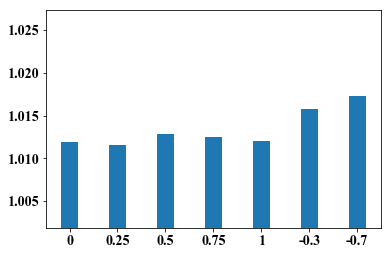

In [40]:
for k,v in scores.items():
    print('%s: \t%f' % (k,v))
plot.custom({sample: list(scores.values())}, options={'x_labels': scores.keys()}, type_='bar', y_scale_margin=0.01, show=True)

In [263]:
genre_dict[sample], sample

([336, 337, 338, 339, 340, 341, 342], '05 Jazz/09 West Coast 152BPM Brushes')

m (40, 10, 1)


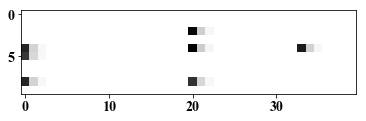

m (40, 10, 1)


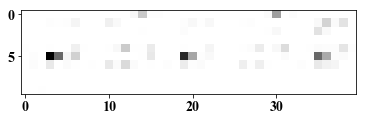

In [261]:
z_sample = x_train_encoded[genre_dict[sample][0]]
plot.single(x_train[genre_dict[sample][0]][:40])
plot.single(generator.predict(np.array([z_sample]))[0,:40])
transformation = transformations[genre_a][genre_b]
z_transformed = []
d = {}
for a in [0, 0.25, 0.5, 0.75, 1, -0.5]:
    z_ = models.apply_transformation(z_sample, transformation, a)
#     x_ = generator.predict(np.array([z_]))
#     d[a] = x_[0]
    z_transformed.append(z_)

x_generated = generator.predict(np.array(z_transformed))

In [146]:
# dict({0:x_generated})

In [244]:
# import importlib
# importlib.reload(models)
# utils.reload(utils)
utils.reload(utils, models, plot)

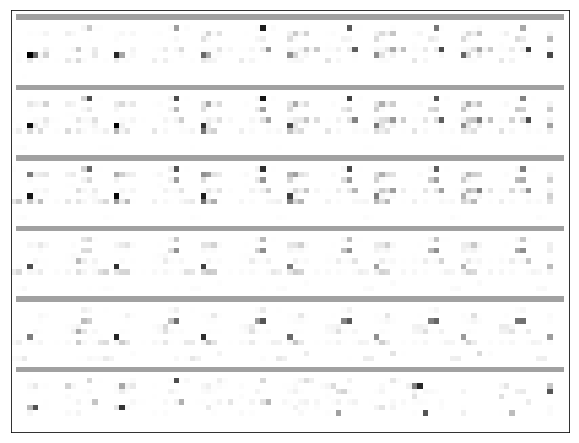

In [245]:
# latent_space = models.gen_latent(generator, latent_dim=latent_dim, n=3, m=2, plot_result=True)
plot.multi(x_generated, crop_size=100)

In [248]:
for i in range(x_generated.shape[0]):
    x_ = x_generated[i]
    mid = midi.decode.track(context, x_)
    io.export_midifile(mid, config.export_dir + ('x-generated-%i'%i))

 [INFO] : 
 |  len, max_t
 |  4.005208333333334
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.9552083333333337
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.9552083333333345
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.955208333333334
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.955208333333334
 |  4.0
 [INFO] : 
 |  len, max_t
 |  3.530208333333334
 |  4.0


In [230]:
def summarize(data):
    """data :: {samples: {genre a: {genre b: grid}}}
    grid = {parameter: outcome}
    
    return :: {parameter: [value] }
    """
    summary = collections.defaultdict(list)
    for original in data.keys():
        for genre_a in data[original].keys():
            for genre_b, grid in data[original][genre_a].items():
                for k,v in grid.items():
                    summary[k].append(v)
    return summary

def evaluate(data):
    """
    data :: {parameter: [value] }
    return :: {statistic: {parameter: value}}
    """
    result = utils.summary_multi(data, mode=list)
    std = []
    for k,v in data.items():
        std.append(np.std(v))
    
    result['std'] = std
    print(result['mean'])
    return result

In [231]:
result = summarize(labelled_result)
x_labels = result.keys()
summary = evaluate(result)
summary_ = summary.copy() # {'Mean': summary['mean'], 'Median': summary['median']}
summary_.pop('std');

[0.9876807875965864, 0.9857763601463576, 0.9853154384665621, 0.9850345093826662, 0.9837582777409346, 0.98361560838528, 0.9846950789512351]


In [232]:
io.save_dict(config.results_dir, 'ncd_result-summary', summary)

'../results/ncd_result-summary.csv'

In [233]:
x_labels

dict_keys([0, 0.25, 0.5, 0.75, 1, -0.3, -0.7])

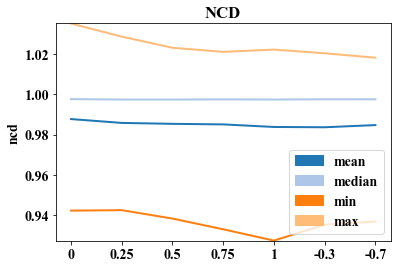

In [234]:
options = {'x_labels': x_labels, 'x_label':'Transformation intensity', 'y_label': 'ncd', 'legend':True}
plot.custom(summary_, 'NCD', options,
            type_='line', min_y_scale=None, max_y_scale=None, y_scale_margin=0.0001, show=True)

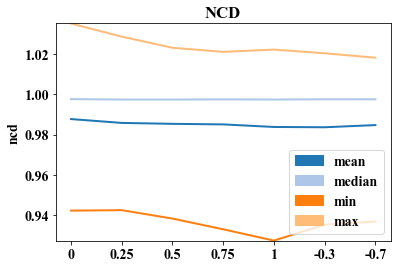

In [235]:
plot.custom(summary_, 'NCD', options,
            type_='line', min_y_scale=None, max_y_scale=None, y_scale_margin=0.0001, show=True)

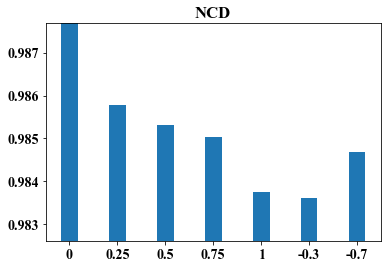

In [236]:
options = {'x_labels': x_labels}
# custom(summary, 'NCD', options, relative=True, show=True)
plot.custom({'Mean':summary['mean']}, 'NCD', options, type_='bar', min_y_scale=None, max_y_scale=None, y_scale_margin=0.001, show=True)

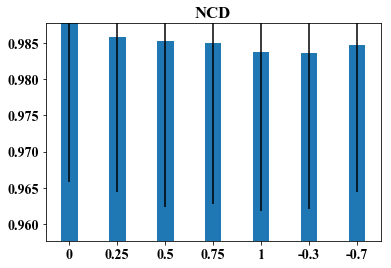

In [237]:
options = {'x_labels': x_labels,}
# custom(summary, 'NCD', options, relative=True, show=True)
std = {'Mean': summary['std'], 'Median': summary['std']}
plot.custom({'Mean':summary['mean']}, 'NCD', options, type_='bar',std=std, min_y_scale=None, max_y_scale=None, y_scale_margin=0.03, show=True)

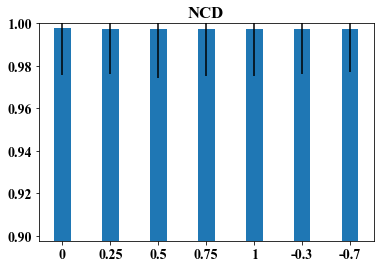

In [238]:
plot.custom({'Median':summary['median']}, 'NCD', options, type_='bar', std=std, relative=True, show=True)

In [239]:
result.keys()

dict_keys([0, 0.25, 0.5, 0.75, 1, -0.3, -0.7])

In [240]:
import scipy.stats

In [241]:
# assume all distributions are related, do not shuffle
# i.e. param1[0] is related to param2[0]
def evaluate(data, f=scipy.stats.ttest_rel, p=0.05,win_c=lambda x,y: x>y):
    result = {}
    for k,v in data.items():
        for other_k, other_v in data.items():
            if not k == other_k:
                score = scipy.stats.ttest_rel(v, other_v)                
                won = win_c(np.mean(v), np.mean(other_v))
                significant = won and score.pvalue < p
                result['%s/%s' % (k,other_k)] = (won, significant)
                print('%s vs %s: \t' % (k, other_k), won, significant, score.pvalue)

In [242]:
evaluate(result)

0 vs 0.25: 	 True False 0.7236858729912461
0 vs 0.5: 	 True True 0.01706050922758777
0 vs 0.75: 	 True False 0.10289882568846348
0 vs 1: 	 True False 0.5867782608459979
0 vs -0.3: 	 False False 0.4595017662220092
0 vs -0.7: 	 False False 0.028485523063950715
0.25 vs 0: 	 False False 0.7236858729912461
0.25 vs 0.5: 	 True False 0.06627441941876183
0.25 vs 0.75: 	 True True 0.02228757396457292
0.25 vs 1: 	 True False 0.6523267900231289
0.25 vs -0.3: 	 False False 0.4773928662359376
0.25 vs -0.7: 	 False False 0.06702927988226494
0.5 vs 0: 	 False False 0.01706050922758777
0.5 vs 0.25: 	 False False 0.06627441941876183
0.5 vs 0.75: 	 True False 0.8433371932959175
0.5 vs 1: 	 False False 0.2856443993451285
0.5 vs -0.3: 	 False False 0.054365182331066075
0.5 vs -0.7: 	 False False 0.011525524556094253
0.75 vs 0: 	 False False 0.10289882568846348
0.75 vs 0.25: 	 False False 0.02228757396457292
0.75 vs 0.5: 	 False False 0.8433371932959175
0.75 vs 1: 	 False False 0.07700822418177207
0.75 vs 

In [243]:
evaluate(result, scipy.stats.ttest_ind)

0 vs 0.25: 	 True False 0.7236858729912461
0 vs 0.5: 	 True True 0.01706050922758777
0 vs 0.75: 	 True False 0.10289882568846348
0 vs 1: 	 True False 0.5867782608459979
0 vs -0.3: 	 False False 0.4595017662220092
0 vs -0.7: 	 False False 0.028485523063950715
0.25 vs 0: 	 False False 0.7236858729912461
0.25 vs 0.5: 	 True False 0.06627441941876183
0.25 vs 0.75: 	 True True 0.02228757396457292
0.25 vs 1: 	 True False 0.6523267900231289
0.25 vs -0.3: 	 False False 0.4773928662359376
0.25 vs -0.7: 	 False False 0.06702927988226494
0.5 vs 0: 	 False False 0.01706050922758777
0.5 vs 0.25: 	 False False 0.06627441941876183
0.5 vs 0.75: 	 True False 0.8433371932959175
0.5 vs 1: 	 False False 0.2856443993451285
0.5 vs -0.3: 	 False False 0.054365182331066075
0.5 vs -0.7: 	 False False 0.011525524556094253
0.75 vs 0: 	 False False 0.10289882568846348
0.75 vs 0.25: 	 False False 0.02228757396457292
0.75 vs 0.5: 	 False False 0.8433371932959175
0.75 vs 1: 	 False False 0.07700822418177207
0.75 vs 